In [1]:
import os
from datetime import timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skimage.io import imread, imsave
from skimage.filters import gaussian
from skimage.registration import phase_cross_correlation
from skimage.transform import EuclideanTransform, warp

In [2]:
def map_func(p, edt, rs):
    rstep = np.mean(np.diff(rs))
    npos = p.shape[0]
    for i in range(npos):
        r,t = p[i,:].astype(int)
        p[i,0] = (edt[t,:,:].max() - rs[r]) / rstep
    return p

In [3]:
# data files selected:
# OK 2023_11_28 pAAA Tweez Pos 1
# OK 2023_12_06 pLPT20 Tweez Pos 4
# OK 2023_11_17 pLPT119 Tweez pos 3
# OK 2023_12_06 pLPT20 IPTG Tweez pos 11
# OK 2023_12_08 pLPT20 aTc Tweez pos 35
# OK 2023_12_04 pLPT107 Tweez pos 7
# OK 2023_12_04 pLPT107 IPTG Tweez pos 31
# OK 2023_12_08 pLPT107 aTc Ti Pos 14

In [38]:
path_ext = '/media/guillermo/Expansion/Thesis GY/3. Analyzed files'
folder_results = 'results'
folder_velocity = 'velocity_data'

scopes = {'Tweez scope': 'TiTweez', 'Ti scope': 'Ti'}
dnas = {'pLPT20&pLPT41': 'pLPT20&41', 'pLPT119&pLPT41': 'pLPT119&41', 'pAAA': 'pAAA', 'pLPT107&pLPT41': 'pLPT107&41'}

exp_date = '2023_11_28'
vector = 'pAAA'
#vector = 'pLPT107&pLPT41'
#vector = 'pLPT20&pLPT41'
#vector = 'pLPT119&pLPT41'

chem = ''
#chem = 'IPTG'
#chem = 'aTc'
scope_name = 'Tweez scope'
pos = 1

path_scope = os.path.join(path_ext, scope_name)
path = os.path.join(path_scope, exp_date)
path_results = os.path.join(path,folder_results, f"pos{pos}")
path_velocity = os.path.join(path,folder_velocity, f"pos{pos}")

fname = f'{exp_date}_10x_1.0x_{dnas[vector]}_{scopes[scope_name]}_Pos{pos}.ome.tif'

if vector == 'pLPT20&pLPT41' or vector == 'pLPT119&pLPT41':
    yfp_chn = 0
    cfp_chn = 1
    ph_chn = 2
    fluo_chns = 2
else:
    rfp_chn = 0
    yfp_chn = 1
    cfp_chn = 2
    ph_chn = 3
    fluo_chns = 3

#### Crop image and EDT

All images and edt are considered up to frame 216 (36 hours)

In [39]:
#tf = 256
tf = 216
im_all = imread(os.path.join(path,fname))[:tf,:,:,:]
nt,nx,ny,nc = im_all.shape
bg = np.zeros((nc,))
for c in range(nc):
    bg[c] = im_all[0,:100,:100,c].mean()

edt = np.load(os.path.join(path_results,'edt.npy'))[:tf,:,:]
edt = edt[:,:,:]

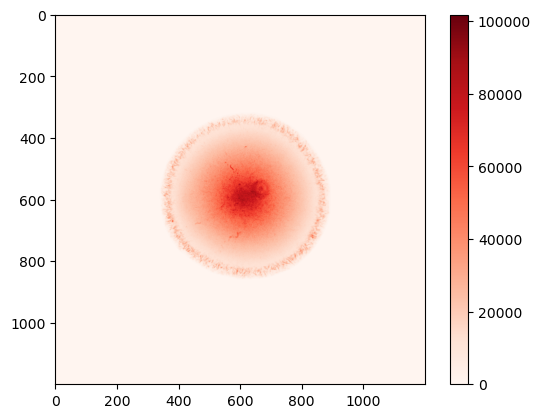

In [6]:
# just for visualization
plt.imshow(im_all[100,:,:,0]*edt[100,:,:],cmap='Reds')
plt.colorbar()

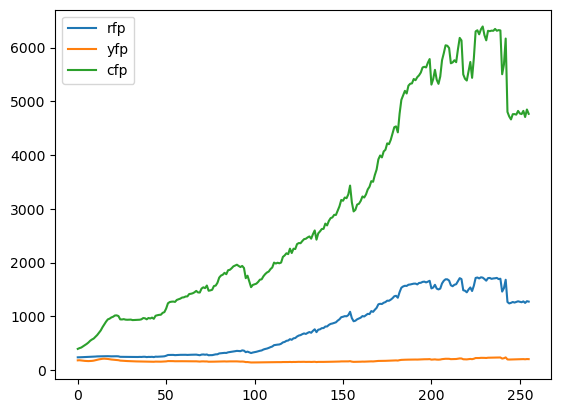

In [7]:
mean_fluo = np.zeros((nt,nc-1))
for t in np.arange(nt):
    for c in np.arange(nc-1):
        mean_fluo[t,c] = im_all[t,edt[t,:,:]>0,c].mean()
plt.plot(mean_fluo[:,0],label='rfp')
plt.plot(mean_fluo[:,1],label='yfp')
plt.plot(mean_fluo[:,2],label='cfp')
plt.legend()
plt.show()

In [8]:
im_all_bk = im_all
edt_bk = edt

In [67]:
# use for 2023_12_04 pLPT107 Tweez pos14, that it's in the edge of the image
"""
## pad the image so it does not crop outside the image
edt = np.pad(edt, ((0,0),(256,256),(256,256)))
im_all = np.pad(im_all, ((0,0),(256,256),(256,256),(0,0)))
nt,nx,ny = edt.shape
"""

'\n## pad the image so it does not crop outside the image\nedt = np.pad(edt, ((0,0),(256,256),(256,256)))\nim_all = np.pad(im_all, ((0,0),(256,256),(256,256),(0,0)))\nnt,nx,ny = edt.shape\n'

In [27]:
im_all = im_all_bk
edt = edt_bk
nt,nx,ny,nc = im_all.shape

In [28]:
y,x = np.meshgrid(np.arange(nx), np.arange(ny))
edt0 = edt[-1,:,:]
minx = x[edt0>0].min()
maxx = x[edt0>0].max()
miny = y[edt0>0].min()
maxy = y[edt0>0].max()
w = maxx - minx
w = int(w//2) * 2
h = maxy - miny
h = int(h//2) * 2

print(w,h)
pad = 32

crop_im_all = np.zeros((nt,w+2*pad,h+2*pad,nc))
crop_edt = np.zeros((nt,w+2*pad,h+2*pad))
print(crop_im_all.shape)
print(crop_edt.shape)

for t in range(nt):
    tedt = edt[t,:,:]
    cx = int(x[tedt>0].mean())
    cy = int(y[tedt>0].mean())

    # filter all channels
    #cim = gaussian(im_all[t,cx - w//2 - pad:cx + w//2 + pad,cy - h//2 - pad:cy + h//2 + pad, :], 1)
    
    # filter no channels
    #cim = im_all[t,cx - w//2 - pad:cx + w//2 + pad,cy - h//2 - pad:cy + h//2 + pad, :]
    
    # filter just one channel
    #"""
    cim = np.zeros((w+2*pad,h+2*pad,nc))
    #cim[:,:,0] = gaussian(im_all[t,cx - w//2 - pad:cx + w//2 + pad,cy - h//2 - pad:cy + h//2 + pad, 0], 1)
    cim[:,:,0] = im_all[t,cx - w//2 - pad:cx + w//2 + pad,cy - h//2 - pad:cy + h//2 + pad, 0]
    #cim[:,:,1] = im_all[t,cx - w//2 - pad:cx + w//2 + pad,cy - h//2 - pad:cy + h//2 + pad, 1]
    cim[:,:,1] = gaussian(im_all[t,cx - w//2 - pad:cx + w//2 + pad,cy - h//2 - pad:cy + h//2 + pad, 1], 3)
    #cim[:,:,2] = gaussian(im_all[t,cx - w//2 - pad:cx + w//2 + pad,cy - h//2 - pad:cy + h//2 + pad, 2], 1)
    cim[:,:,2] = im_all[t,cx - w//2 - pad:cx + w//2 + pad,cy - h//2 - pad:cy + h//2 + pad, 2]
    cim[:,:,3] = im_all[t,cx - w//2 - pad:cx + w//2 + pad,cy - h//2 - pad:cy + h//2 + pad, 3]
    #"""
    crop_im_all[t,:,:,:] = cim
    crop_edt[t,:,:] = tedt[cx - w//2 - pad:cx + w//2 + pad,cy - h//2 - pad:cy + h//2 + pad]

550 564
(256, 614, 628, 4)
(256, 614, 628)


In [155]:
"""
## registration
for t in range(1,nt):
    shift,err,phase = phase_cross_correlation(crop_im_all[0,:,:,ph_chn].astype(float), crop_im_all[t,:,:,ph_chn].astype(float))
    tform = EuclideanTransform(translation=[shift[1],shift[0]])
    for c in range(nc):
        crop_im_all[t,:,:,c] = warp(crop_im_all[t,:,:,c].astype(float), tform.inverse, mode='reflect')
    crop_edt[t,:,:] = warp(crop_edt[t,:,:].astype(float), tform.inverse)
"""

"\n## registration\nfor t in range(1,nt):\n    shift,err,phase = phase_cross_correlation(crop_im_all[0,:,:,ph_chn].astype(float), crop_im_all[t,:,:,ph_chn].astype(float))\n    tform = EuclideanTransform(translation=[shift[1],shift[0]])\n    for c in range(nc):\n        crop_im_all[t,:,:,c] = warp(crop_im_all[t,:,:,c].astype(float), tform.inverse, mode='reflect')\n    crop_edt[t,:,:] = warp(crop_edt[t,:,:].astype(float), tform.inverse)\n"

In [21]:
np.save(os.path.join(path_results,'crop_edt.npy'), crop_edt)

In [29]:
im_all = crop_im_all
edt = crop_edt
del crop_im_all
del crop_edt

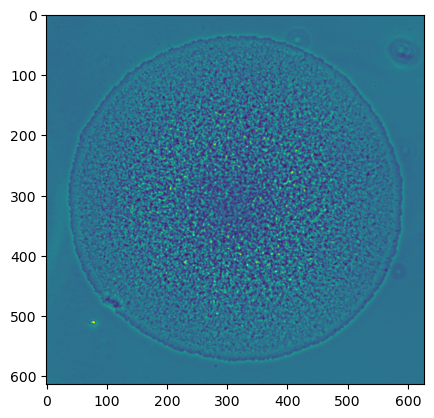

In [30]:
plt.imshow(im_all[-1,:,:,3])

#### Normalize cropped image

In [31]:
nt,nx,ny,nc = im_all.shape

normed_im = np.zeros((nt,nx,ny,nc))
normed_im[:,:,:,ph_chn] = im_all[:,:,:,ph_chn]
for t in range(nt):
    tedt = edt[t,:,:]
    ## all but phase
    for c in range(nc-1):
        tcim = im_all[t,:,:,c]
        min_tcim = tcim[tedt>0].min()
        max_tcim = tcim[tedt>0].max()
        # Normalise fluo
        ntcim = (tcim - min_tcim) / (max_tcim - min_tcim)
        # Remove fluo from bg
        ntcim[tedt==0] = 0 # np.nan
        normed_im[t,:,:,c] = ntcim

In [32]:
imsave(f'normed_{fname}', normed_im)

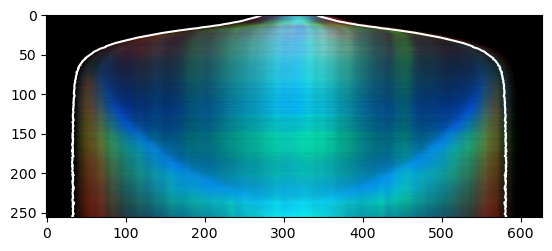

In [33]:
cx = nx // 2
cy = ny // 2
if fluo_chns == 2:
    normed_im_aux = np.zeros_like(normed_im)
    normed_im_aux[:,:,:,1] = normed_im[:,:,:,0]
    normed_im_aux[:,:,:,2] = normed_im[:,:,:,1]
    plt.imshow(normed_im_aux[:,cx-16:cx+16,:,:].mean(axis=1))
elif fluo_chns == 3:
    plt.imshow(normed_im[:,cx-16:cx+16,:,:ph_chn].mean(axis=1))

radius = edt.max(axis=(1,2))
plt.plot(cx + radius, np.arange(nt), 'w')
plt.plot(cx - radius, np.arange(nt), 'w')

#### Normed kymo

In [35]:
## normalized kymo
nt,nx,ny,nc = im_all.shape
nr = 64
rw = 16
rs = np.linspace(rw, edt.max(), nr)
#kymo = np.zeros((nt,nr,3)) + np.nan
nkymo = np.zeros((nt,nr,nc-1)) + np.nan
for t in range(nt):
    for c in range(nc-1):
        for ri in range(nr):
            tedt = edt[t,:,:]
            idx = np.abs(tedt - rs[ri]) < rw
            if np.sum(idx)>0:
                #ntcim = im_all[t,:,:,1+c]
                #kymo[t,ri,c] = np.nanmean(ntcim[idx])
                ntcnim = normed_im[t,:,:,c]
                nkymo[t,ri,c] = np.nanmean(ntcnim[idx])
np.save(os.path.join(path_results,'nkymo.npy'), nkymo)

## warped normalized kymo
wnkymo = np.zeros_like(nkymo)
for c in range(nc-1):
    wnkymo[:,:,c] = warp(nkymo[:,:,c], map_func, {'edt':edt, 'rs':rs})
wnkymo[np.isnan(nkymo)] = np.nan
np.save(os.path.join(path_results,'wnkymo.npy'),wnkymo)

# for plot labels
df = pd.read_excel('../data_processed.xlsx')
## preparing labels
df_pos = df[(df['Date'].dt.strftime('%Y_%m_%d') == exp_date) &
    (df.Machine == scope_name) &
    (df.DNA == vector) &
    (df.Position == pos)]

j = df_pos.index[0]
df_pos.loc[:, 't_im'] = pd.to_datetime(df_pos['t_im'], format='%H:%M:%S')
df_pos.loc[:, 't_incub'] = pd.to_datetime(df_pos['t_incub'], format='%H:%M:%S')

time_im = df_pos.loc[j, 't_im']
time_incub = df_pos.loc[j, 't_incub']

delta_im = timedelta(hours=time_im.hour, minutes=time_im.minute, seconds=time_im.second)
delta_incub = timedelta(hours=time_incub.hour, minutes=time_incub.minute, seconds=time_incub.second)

# Calculate the difference
incub_time_s = delta_im - delta_incub
incub_time_n = incub_time_s.total_seconds() / 60

time_points = np.arange(0, df_pos.loc[j, 'exp length'])[:nt] * 10 + incub_time_n
time_strings = [f"{int(tp // 60):02d}" for tp in time_points]  # Ensure two digits for hours

# Select labels at intervals (e.g., every 75 points)
interval = 50
indices = np.arange(0, len(time_points), interval)
selected_time_strings = [time_strings[i] for i in indices]
## distance labels
ylim = edt.max() * df_pos['um_px'].values[0]
edt_max = edt.max(axis=(1,2))

/home/guillermo/anaconda3/envs/popdyn/lib/python3.11/site-packages/matplotlib/cm.py:489: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


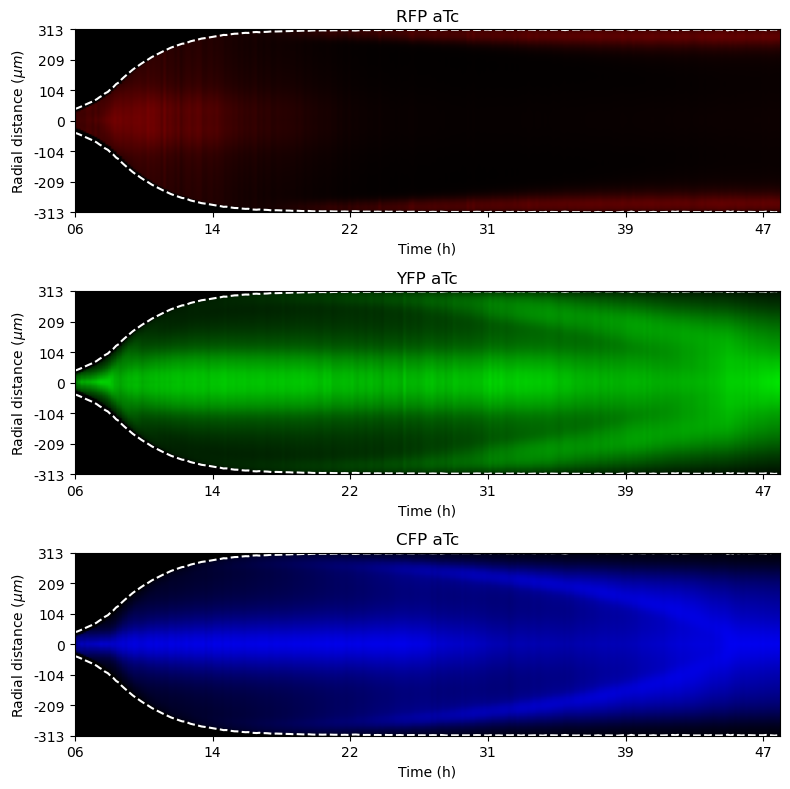

/home/guillermo/anaconda3/envs/popdyn/lib/python3.11/site-packages/matplotlib/cm.py:489: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


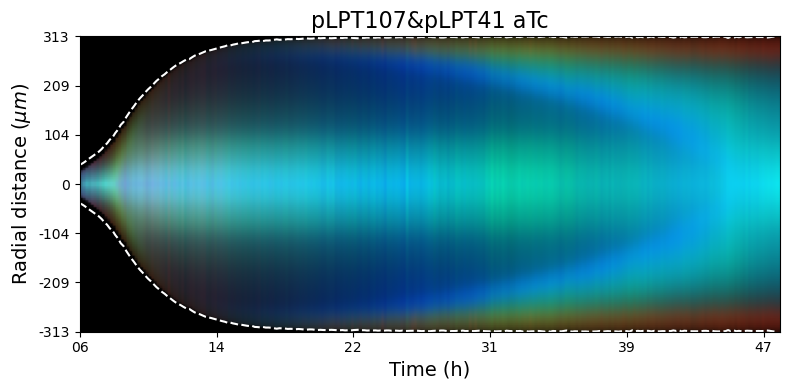

In [36]:
## plots
um_px = df_pos['um_px'].values[0]
if fluo_chns == 2:
    wnkymoy = np.zeros((nt,nr,nc))
    wnkymoc = np.zeros((nt,nr,nc))
    wnkymoy[:,:,1] = wnkymo[:,:,0]
    wnkymoc[:,:,2] = wnkymo[:,:,1]
    
    fig, axs = plt.subplots(2, 1, figsize=(8, 8))
    
    # Plot YFP
    axs[0].imshow(np.hstack([wnkymoy[:, ::-1, :], wnkymoy[:, :, :]]).transpose([1, 0, 2]), 
                  aspect='auto', 
                  extent=[0, nt, -ylim, ylim])
    axs[0].plot(um_px*edt_max, 'w--')
    axs[0].plot(-um_px*edt_max, 'w--')
    axs[0].set_xlabel('Time (h)')
    axs[0].set_ylabel('Radial distance ($\mu m)$')
    axs[0].set_title(f'YFP {chem}')
    axs[0].set_xticks(indices)
    axs[0].set_xticklabels(selected_time_strings)
    yticks = np.linspace(-ylim, ylim, num=7)
    axs[0].set_yticks(yticks)
    axs[0].set_yticklabels([f'{int(tick)}' for tick in yticks])
    
    # Plot CFP
    axs[1].imshow(np.hstack([wnkymoc[:, ::-1, :], wnkymoc[:, :, :]]).transpose([1, 0, 2]), 
                  aspect='auto', 
                  extent=[0, nt, -ylim, ylim])
    axs[1].plot(um_px*edt_max, 'w--')
    axs[1].plot(-um_px*edt_max, 'w--')
    axs[1].set_xlabel('Time (h)')
    axs[1].set_ylabel('Radial distance ($\mu m)$')
    axs[1].set_title(f'CFP {chem}')
    axs[1].set_xticks(indices)
    axs[1].set_xticklabels(selected_time_strings)
    yticks = np.linspace(-ylim, ylim, num=7)
    axs[1].set_yticks(yticks)
    axs[1].set_yticklabels([f'{int(tick)}' for tick in yticks])
    
    plt.tight_layout()
    plt.savefig(f'Ch4/normed_kymo_{vector}_split_{chem}_pos{pos}.png', dpi=300, bbox_inches='tight', pad_inches=0)
    plt.show()

    ## Plot composite
    wnkymoc_aux = np.zeros((nt,nr,nc))
    wnkymoc_aux[:,:,1] = wnkymo[:,:,0]
    wnkymoc_aux[:,:,2] = wnkymo[:,:,1]
    plt.figure(figsize=((8,4)))
    plt.imshow(np.hstack([wnkymoc_aux[:,::-1,:],wnkymoc_aux[:,:,:]]).transpose([1,0,2]), 
               aspect='auto', 
               extent=[0,nt,-ylim,ylim])
    plt.plot(um_px*edt_max, 'w--')
    plt.plot(-um_px*edt_max, 'w--')
    plt.xlabel('Time (h)', fontsize=14)
    plt.ylabel('Radial distance ($\mu m)$', fontsize=14)
    plt.title(f'{vector} {chem}', fontsize=16)
    plt.xticks(ticks=indices, labels=selected_time_strings)
    yticks = np.linspace(-ylim, ylim, num=7)
    plt.yticks(ticks=yticks, labels=[f'{int(tick)}' for tick in yticks])
    
    plt.tight_layout()
    plt.savefig(f'Ch4/normed_kymo_{vector}_{chem}_pos{pos}.png', dpi=300, bbox_inches='tight', pad_inches=0)
    plt.show()
    
elif fluo_chns == 3:# & vector != 'pAAA':
    wnkymor = np.zeros((nt,nr,nc-1))
    wnkymoy = np.zeros((nt,nr,nc-1))
    wnkymoc = np.zeros((nt,nr,nc-1))
    wnkymor[:,:,0] = wnkymo[:,:,0]    
    wnkymoy[:,:,1] = wnkymo[:,:,1]
    wnkymoc[:,:,2] = wnkymo[:,:,2]
    fig, axs = plt.subplots(3, 1, figsize=(8, 8))
    # Plot RFP
    axs[0].imshow(np.hstack([wnkymor[:, ::-1, :], wnkymor[:, :, :]]).transpose([1, 0, 2]), 
                  aspect='auto', 
                  extent=[0, nt, -ylim, ylim])
    axs[0].plot(um_px*edt_max, 'w--')
    axs[0].plot(-um_px*edt_max, 'w--')
    axs[0].set_xlabel('Time (h)')
    axs[0].set_ylabel('Radial distance ($\mu m)$')
    axs[0].set_title(f'RFP {chem}')
    axs[0].set_xticks(indices)
    axs[0].set_xticklabels(selected_time_strings)
    yticks = np.linspace(-ylim, ylim, num=7)
    axs[0].set_yticks(yticks)
    axs[0].set_yticklabels([f'{int(tick)}' for tick in yticks])
    
    # Plot YFP
    axs[1].imshow(np.hstack([wnkymoy[:, ::-1, :], wnkymoy[:, :, :]]).transpose([1, 0, 2]), 
                  aspect='auto', 
                  extent=[0, nt, -ylim, ylim])
    axs[1].plot(um_px*edt_max, 'w--')
    axs[1].plot(-um_px*edt_max, 'w--')
    axs[1].set_xlabel('Time (h)')
    axs[1].set_ylabel('Radial distance ($\mu m)$')
    axs[1].set_title(f'YFP {chem}')
    axs[1].set_xticks(indices)
    axs[1].set_xticklabels(selected_time_strings)
    yticks = np.linspace(-ylim, ylim, num=7)
    axs[1].set_yticks(yticks)
    axs[1].set_yticklabels([f'{int(tick)}' for tick in yticks])
    
    # Plot CFP
    axs[2].imshow(np.hstack([wnkymoc[:, ::-1, :], wnkymoc[:, :, :]]).transpose([1, 0, 2]), 
                  aspect='auto', 
                  extent=[0, nt, -ylim, ylim])
    axs[2].plot(um_px*edt_max, 'w--')
    axs[2].plot(-um_px*edt_max, 'w--')
    axs[2].set_xlabel('Time (h)')
    axs[2].set_ylabel('Radial distance ($\mu m)$')
    axs[2].set_title(f'CFP {chem}')
    axs[2].set_xticks(indices)
    axs[2].set_xticklabels(selected_time_strings)
    yticks = np.linspace(-ylim, ylim, num=7)
    axs[2].set_yticks(yticks)
    axs[2].set_yticklabels([f'{int(tick)}' for tick in yticks])
    
    plt.tight_layout()
    plt.savefig(f'Ch4/normed_kymo_{vector}_split_{chem}_pos{pos}.png', dpi=300, bbox_inches='tight', pad_inches=0)
    plt.show()

    ## Plot composite
    plt.figure(figsize=(8,4))
    plt.imshow(np.hstack([wnkymo[:,::-1,:],wnkymo[:,:,:]]).transpose([1,0,2]), 
               aspect='auto', 
               extent=[0,nt,-ylim,ylim])
    plt.plot(um_px*edt_max, 'w--')
    plt.plot(-um_px*edt_max, 'w--')
    plt.xlabel('Time (h)', fontsize=14)
    plt.ylabel('Radial distance ($\mu m)$', fontsize=14)
    plt.title(f'{vector} {chem}', fontsize=16)
    plt.xticks(ticks=indices, labels=selected_time_strings)
    yticks = np.linspace(-ylim, ylim, num=7)
    plt.yticks(ticks=yticks, labels=[f'{int(tick)}' for tick in yticks])
    
    plt.tight_layout()
    plt.savefig(f'Ch4/normed_kymo_{vector}_{chem}_pos{pos}.png', dpi=300, bbox_inches='tight', pad_inches=0)
    plt.show()


In [1]:
wnkymor.shape

NameError: name 'wnkymor' is not defined